In [1]:
import itertools
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt 
#%matplotlib inline

import qiskit
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import I, X, Y, Z, PauliSumOp
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import InequalityToEquality
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.converters import IntegerToBinary


from docplex.mp.model import Model
from sklearn import manifold
from matplotlib import pyplot as plt

/home/keisuke/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


## Question1. 
- Formulation TSP as MIP and convert the formulation into a Docplex model

## 1.1 Define classes

In [287]:
# Generating a graph with 3 nodes 
N = 3
V = np.arange(0,N,1)
G = nx.Graph()
G.add_nodes_from(V)


### 1.1.1 class for drawing graph

In [4]:
class draw_graph():
    
    def __init__(self, G, pos):
        
        self.G = G
        self.colors = ['r' for node in G.nodes()]
        self.pos = pos
    def draw(self):
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=self.colors, node_size=300,alpha=1, ax=default_axes, pos=self.pos)
    
    def add_edge(self,E):
        self.G.add_weighted_edges_from(E)

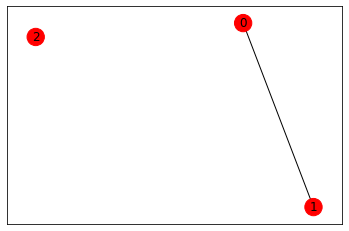

In [288]:
draw = draw_graph(G,pos)
draw.add_edge([(0,1,D[0,1])])
draw.draw()

## 1.1.2 class return cplex form of TSP

MIP form of TSP is

$$
i, j  \in \{0,..,N-1\} \\ \\
\text{optimize} \sum_{i,j} D_{ij}x_{ij}\\
\text{under the constraints} \\\sum_i x_{ij} = 1 \\\sum_j x_{ij} = 1\\
t_i - t_j + nx_{ij} <= n-1,\ \ \ 1<= i \neq j<=n-1
$$

$x_{ij} \in  \{0,1\}$. $  \{t_i\}_{i=1,..,N-1} $ are integer and bounded $0 \leq t_i < N-1$ 

In [289]:
class TSP():
    def __init__(self, N):
        
        D = np.random.rand(N*N).reshape(N,N)

        self.D = D.T + D # Distance Matrix
        for n in range(N):
            self.D[n,n] = 0
        self.N = N

                
        V = np.arange(0,N,1)
        self.G = nx.Graph()
        self.G.add_nodes_from(V)
        
        mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
        self.pos = mds.fit_transform(self.D)

        
                
    def draw(self, edge=None):
        draw = draw_graph(self.G, self.pos)
        if edge:
            draw.add_edge(edge)
        draw.draw()
        
    def return_mod(self):
        N = self.N
        
        mod = Model('TSP')
        
        var = {}
        t = []
        summation = []
        for n1 in range(N):
            var[n1] = {}
            for n2 in range(N):
                if n1!=n2:
                    var_ = mod.binary_var(name=f'x{n1}{n2}')
                    summation.append(var_ * self.D[n1][n2])
                    var[n1][n2] = var_
            t.append(mod.integer_var(name=f't{n1+1}',lb=0, ub=N-1))

        print(var)
        mod.minimize(mod.sum(summation))

        for n1 in range(N):
            constraint1 = []
            constraint2 = []
            for n2 in range(N):
                if n1!=n2:
                    constraint1.append(var[n1][n2])
                    constraint2.append(var[n2][n1])
            mod.add_constraint(mod.sum(constraint1)==1)
            mod.add_constraint(mod.sum(constraint2)==1)

        # constraints for not creating subloops

        for i in range(1,N):
            for j in range(1,N):
                if i!=j:
                    mod.add_constraint(t[i-1]-t[j-1]+N*var[i][j] <= N-1)
        self.mod = mod
        return mod
    
    def solve(self):
        self.mod()
        return self.mod.solve()

{0: {1: docplex.mp.Var(type=B,name='x01'), 2: docplex.mp.Var(type=B,name='x02')}, 1: {0: docplex.mp.Var(type=B,name='x10'), 2: docplex.mp.Var(type=B,name='x12')}, 2: {0: docplex.mp.Var(type=B,name='x20'), 1: docplex.mp.Var(type=B,name='x21')}}


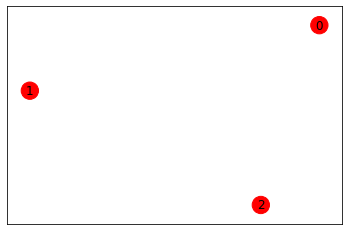

In [290]:
tsp = TSP(3)
mod = tsp.return_mod()
tsp.draw()

In [291]:
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: 1.041504257522 x01 + 0.830403480461 x02 + 1.041504257522 x10
      + 0.956977294194 x12 + 0.830403480461 x20 + 0.956977294194 x21
Subject To
 c1: x01 + x02 = 1
 c2: x10 + x20 = 1
 c3: x10 + x12 = 1
 c4: x01 + x21 = 1
 c5: x20 + x21 = 1
 c6: x02 + x12 = 1
 c7: t1 + 3 x12 - t2 <= 2
 c8: - t1 + t2 + 3 x21 <= 2

Bounds
 0 <= x01 <= 1
 0 <= x02 <= 1
       t1 <= 2
 0 <= x10 <= 1
 0 <= x12 <= 1
       t2 <= 2
 0 <= x20 <= 1
 0 <= x21 <= 1
       t3 <= 2

Binaries
 x01 x02 x10 x12 x20 x21

Generals
 t1 t2 t3
End



### end of Question1

## Question2 
- Apply VQE and/or QAOA to a TSP instance with 3 cities
 - Make sure that the solution satisfies the constraints
 - Try various classical optimizers and variational forms

## 2.1 First, solve with classical optimizer

In [244]:
edge = []
result = mod.solve().as_index_dict()
for n in range(N*(N-1)):
    if n in result.keys():
        edge.append(from_num(n,N)+(1,))

In [245]:
import re 
edge = []
for key, item in mod.solve().as_dict().items():
    if 'x' in str(key):
        index = re.findall(r'\d',str(key))
        index = [int(ele) for ele in index]
        edge.append(tuple(index) + (0,))

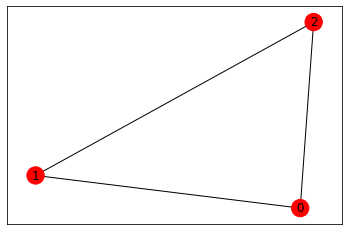

In [246]:
tsp.draw(edge)

### 2.1.2 Confirm that the mod works correctly by solving TSP for N=5

In [247]:
tsp_test = TSP(5)
mod=tsp_test.return_mod()
edge = []
for key, item in mod.solve().as_dict().items():
    if 'x' in str(key):
        index = re.findall(r'\d',str(key))
        index = [int(ele) for ele in index]
        edge.append(tuple(index) + (0,))

{0: {1: docplex.mp.Var(type=B,name='x01'), 2: docplex.mp.Var(type=B,name='x02'), 3: docplex.mp.Var(type=B,name='x03'), 4: docplex.mp.Var(type=B,name='x04')}, 1: {0: docplex.mp.Var(type=B,name='x10'), 2: docplex.mp.Var(type=B,name='x12'), 3: docplex.mp.Var(type=B,name='x13'), 4: docplex.mp.Var(type=B,name='x14')}, 2: {0: docplex.mp.Var(type=B,name='x20'), 1: docplex.mp.Var(type=B,name='x21'), 3: docplex.mp.Var(type=B,name='x23'), 4: docplex.mp.Var(type=B,name='x24')}, 3: {0: docplex.mp.Var(type=B,name='x30'), 1: docplex.mp.Var(type=B,name='x31'), 2: docplex.mp.Var(type=B,name='x32'), 4: docplex.mp.Var(type=B,name='x34')}, 4: {0: docplex.mp.Var(type=B,name='x40'), 1: docplex.mp.Var(type=B,name='x41'), 2: docplex.mp.Var(type=B,name='x42'), 3: docplex.mp.Var(type=B,name='x43')}}


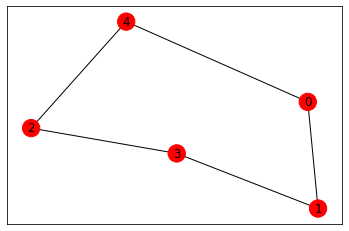

In [248]:
tsp_test.draw(edge)

## 2.2 solve with qiskit

### 2.2.1 Convert docplex type model to the format so that qiskit can deal with

In [285]:
tsp = TSP(3)
mod = tsp.return_mod()

{0: {1: docplex.mp.Var(type=B,name='x01'), 2: docplex.mp.Var(type=B,name='x02')}, 1: {0: docplex.mp.Var(type=B,name='x10'), 2: docplex.mp.Var(type=B,name='x12')}, 2: {0: docplex.mp.Var(type=B,name='x20'), 1: docplex.mp.Var(type=B,name='x21')}}


In [286]:
qp = QuadraticProgram()
qp.from_docplex(mod)

ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)

lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq)

int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qubo)

print(qp_eq_bin)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: - 17.166114650529 x01 - 16.993000744142 x02 - 17.166114650529 x10
      - 69.445967417453 x12 - 16.993000744142 x20 - 69.445967417453 x21
      - 17.549801329723 c6@int_slack@0 - 35.099602659447 c6@int_slack@1
      - 17.549801329723 c6@int_slack@2 - 17.549801329723 c7@int_slack@0
      - 35.099602659447 c7@int_slack@1 - 17.549801329723 c7@int_slack@2 + [
      17.549801329723 x01^2 + 17.549801329723 x01*x02 + 17.549801329723 x01*x21
      + 17.549801329723 x02^2 + 17.549801329723 x02*x12 + 17.549801329723 t1@0^2
      + 35.099602659447 t1@0*t1@1 + 52.649403989170 t1@0*x12
      - 35.099602659447 t1@0*t2@0 - 35.099602659447 t1@0*t2@1
      - 52.649403989170 t1@0*x21 + 17.549801329723 t1@0*c6@int_slack@0
      + 35.099602659447 t1@0*c6@int_slack@1
      + 17.549801329723 t1@0*c6@int_slack@2
      - 17.549801329723 t1@0*c7@int_slack@0
      - 35.099602659447 t1@0*c7@int_slack@1
      - 17.5

### 2.2.2 vqe

In [254]:
seed = 1234
maxiter=100

algorithm_globals.random_seed = seed
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), shots=2000, seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins)
min_eigen_optimizer = MinimumEigenOptimizer(vqe)
result = min_eigen_optimizer.solve(qp_eq_bin)

In [280]:
varnames = [v.name for v in result.variables]

In [268]:
edge = []
for i in range(N):
    for j in range(N):
        if (i!=j) and (result.variables_dict[f'x{i}{j}']==1) :
            edge.append((i,j,0))

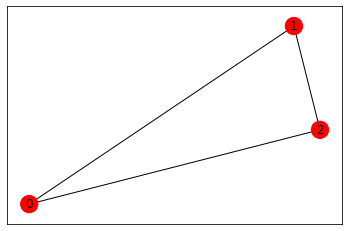

In [270]:
tsp.draw(edge)

### 2.2.3 QAOA

In [283]:
maxiter2 = 100
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins, reps=3)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp_eq_bin)

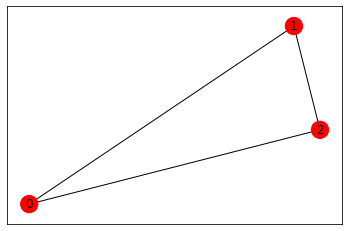

In [284]:
edge = []
for i in range(N):
    for j in range(N):
        if (i!=j) and (result.variables_dict[f'x{i}{j}']==1) :
            edge.append((i,j,0))
tsp.draw(edge)